# Can we use bioinformatics to tell how closely related pathogens are?

In bioinformatics, we (the scientists) often want to compare many different bacteria, viruses, and fungi to understand their related functions. Think about bioinformatics as analyzing the blueprints for all organisms, allowing us to understand more throughly how things work down to the most basic building blocks of life.

Bioinformaticians use many tools to understand the organisms they work with. Today, we will use k-mer distance estimation, a powerful analysis technique that can be used to estimate how similar multiple organism are to one another. By breaking down the genetic sequences of these organisms into smaller fragments known as k-mers, we can find patterns across the genome that make organisms act uniquely, affecting how an organism can act as a pathogen, as well as how it adapts to its environment.

In this module, we will compare several different bacteria and viruses to get an understanding of how closely related these pathogens are. Background on some common human pathogens is found below:

### E. coli (Escherichia coli):
E. coli is a bacteria commonly found in the human GI tract. Some types of E. coli have a gene for a toxin that can make us sick, especially if found in contaminated food or water.

### S. aureus (Staphylococcus aureus):
S. aureus is a bacteria commonly found on human skin. Some types of S. aureus, like MRSA, have become resistant to many antibiotics, and can cause serious skin infections.

### S. pyogenes (Streptococcus pyogenes):
S. pyogenes, also known as Group A strep, is the main cause of strep throat, and can typically be treated with penicllin.

### SARS-CoV-2 (Severe Acute Respiratory Syndrome Coronavirus 2):
SARS-CoV-2 is the virus that causes COVID-19, and is typically spread through respiratory droplets.

### H3N2 (Influenza A virus):
H3N2 is the virus that causes influenza type A in humans, but can also affect birds and other mammals. H3N2 is also spread primarily through respiratory droplets. The H3N2 mutates frequently, warranting development of yearly flu shots aimed at the predicted flu subtype.

# Looking at Our Genomes

The genomes from the previous three bacteria and two viruses were downloaded from the NCBI RefSeq database. NCBI is a centralized hub for genomic data. The NCBI RefSeq database contains genomes of tens of thousands of organisms, carefully curated for public use.

Genomic data is stored in a file format known as FASTA. In this format, there are header lines which start with ">" and sequence lines, which contain the fasta nucleotides.

Firstly, lets look at our data to get an understanding of the FASTA format.

Click on the cell below and hit the play button to run the cell of code. If the code runs successfully, we should see FASTA file output.

In [11]:
import os

# open our FASTA files and look at the contents
for genome in os.scandir("genomes"):
    with open(genome.path) as fasta_file:
        head = ("").join([next(fasta_file) for _ in range(2)])
    print(head)

>NZ_SJLH01000001.1 Streptococcus pyogenes strain SPY5004 MMLPGJGC_1, whole genome shotgun sequence
GATTGACGACTATCCAATTCAACTGCGCAATCATCAATAGAAATAATAAAATCAATCATCGTAGTCACCTCATCTATAGT

>NZ_WIKK01000100.1 Escherichia coli strain J22 NODE_100_length_617_cov_109.672, whole genome shotgun sequence
ATCTGGGCGTTCAGTGATTTCGCCCGCGATCGCCGTGGAGTGTGCGATCCGGAAGCCCGTTGCCTTGCCGGCAATCCCGG

>NZ_VSZA01000001.1 Staphylococcus aureus strain IMT37728 IMT37728_contig00001, whole genome shotgun sequence
ATATATATAAATAAGTTCCCGCATTCATTTTTAAAAAATGGTATAATTAAAGTCTTGATTATTTAGATAAGTGCTTTTTA

>NC_045512.2 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAA

>NC_007373.1 Influenza A virus (A/New York/392/2004(H3N2)) segment 1, complete sequence
AGCAAAAGCAGGTCAATTATATTCAGTATGGAAAGAATAAAAGAACTACGGAACCTGATGTCGCAGTCTCGCACTCGCGA



# What is a K-mer?

As we see in the above FASTA files, genomes are made up of a series of nucleotides "A", "T", "C", or "G". Every genome from the smallest bacteria to the largest animal is made up of these four nucleotides. It is the different ways in which these nucleotides are strung together that defines the different functions an organism can perform.

Think of k-mers as breaking the genome up into the small strings of nucleotides of length k. These small strings are like patterns, and the more they appear in two different genomes, the more similar those genomes are. See the below image comparing three small sequences by their k-mers.



# The k-mer distance estimation code

The next cell contains the code for the k-mer distance estimation program. This includes code for extracting the k-mers for each of our downloaded genomes, computing distance based on the k-mers, and formatting the output into a heatmap. This cell prepares our program to run, but will not complete any calculations yet.

Click on the cell below and hit the play button to run the cell of code.

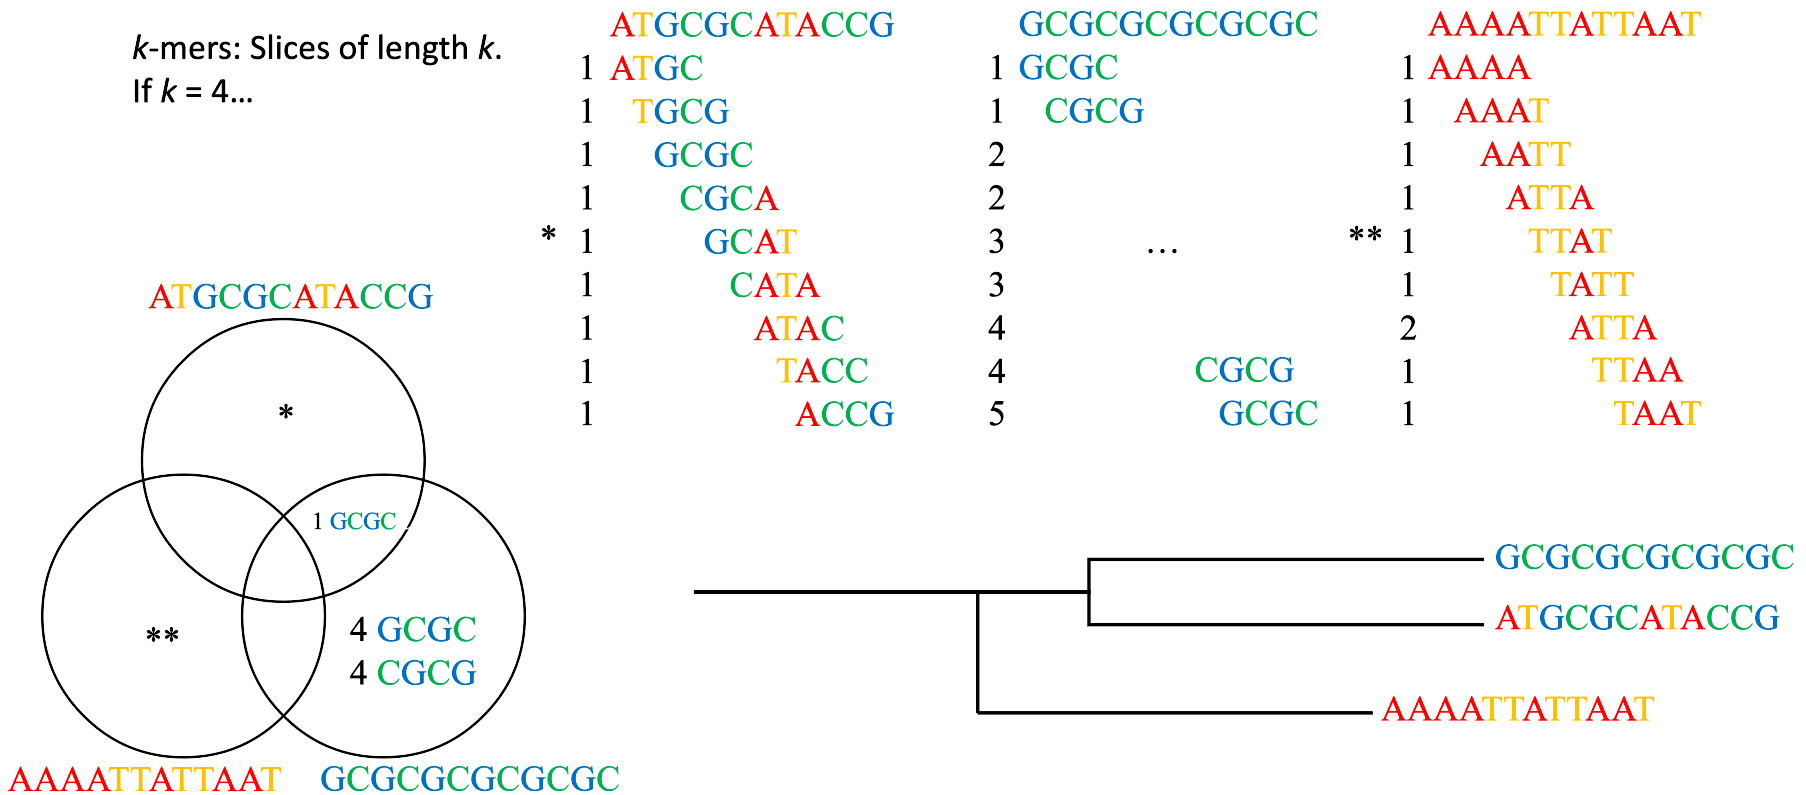

In [8]:
import Bio.SeqIO, math, re, scipy, warnings
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from statistics import pstdev
warnings.filterwarnings("ignore")

# generates kmer dictionary from fasta formatted data
def parse_fasta(fasta, k):
    kmer_dict = {}

    # parses fasta file using SeqRecord iterator
    for record in Bio.SeqIO.parse(fasta, "fasta"):
        seq = record.seq
        regex = "([A-Z][a-z]+)(( [a-z]+)+ ?[1-9]?)"
        match = re.search(regex, record.description)
        try:
            genus = match.group(1)
            species = match.group(2)
            organism = genus + species
        except AttributeError:
            organism = record.description

        # Iterates over all combinations of k continuous nucleotides and adds the kmers to
        # a dictionary with a counter of the number of instances of the kmers
        for nuc_idx in range(len(seq) - (k - 1)):
            kmer = seq[nuc_idx:(nuc_idx + k)]
            kmer_dict.setdefault(kmer, 0)
            kmer_dict[kmer] += 1
            
    print("Parsed {0} -------> Exracted Organism: {1}".format(fasta, organism))
    return (organism, kmer_dict)

# compares the keys in two dictionaries, and adds the missing keys
# from each into one another
def compare_kmer(dict_1, dict_2):
    set_1 = set(dict_1.keys())
    set_2 = set(dict_2.keys())
    diff_keys = list(set_1.symmetric_difference(set_2))
    for key in diff_keys:
        dict_1.setdefault(key, 0)
        dict_2.setdefault(key, 0)

# computes euclidean distance based on two kmer dictionaries
def euclid_kmer(dict_1, dict_2):
    euclid_sum = 0
    for coord in dict_2:
        euclid_sum += (dict_2[coord] - dict_1[coord])**2
    return math.sqrt(euclid_sum)

# normalizes distances in the output matrix to 1
def normalize(distances):
    all_values = []
    for sub in distances:
        for val in sub:
            all_values.append(val)

    minimum = min(all_values)
    maximum = max(all_values)

    # sets values in sub_lists to normalized values
    for sub in distances:
        for idx, val in enumerate(sub):
            norm_val = (val - minimum)/(maximum - minimum)
            sub[idx] = norm_val

    return distances

def matrix_output(samples, k):
    ### {sample_N: {sample_N kmer dict}, ...} ###
    distance_dict = {}
    orgs = []

    # pairs kmer dictionaries with organism names
    for sample in samples:
        org, distance_dict[sample] = parse_fasta(sample, k)
        # adds organism to list for output header
        if org not in orgs:
                orgs.append(org)

    ### {(sample_x, sample_y): dist, ...} ###
    # stores previously computed distance values so program only
    # has to run unique pairs of orgs
    store_compare = {}

    # distance matrix output; list of lists
    distances = []
    for sample_1 in samples:
        sub_dist = []
        for sample_2 in samples:
            # if distance already computed, grab cached value
            if (sample_2, sample_1) in store_compare:
                sub_dist.append(store_compare[sample_2, sample_1])
                continue
            # if samples are the same, dist = 0
            if sample_1 == sample_2:
                sub_dist.append(0.00)
                continue

            # grabs kmer dictionaries from distance_dict
            kmer_1 = distance_dict[sample_1]
            kmer_2 = distance_dict[sample_2]

            compare_kmer(kmer_1, kmer_2)
            # calculates euclidean distance
            dist = euclid_kmer(kmer_1, kmer_2)
            # adds dist to cache dictionary
            store_compare[(sample_1, sample_2)] = dist
            sub_dist.append(dist)

        distances.append(sub_dist)
    return orgs, distances

def make_table(k, orgs, distances):
    # normalizes the data in distances for heatmap output
    D = np.array(normalize(distances))
    
    fig = plt.figure(figsize=(8,8))
    
    # Dendrogram to right of heat map
    ax1 = fig.add_axes([0.91, 0.1, 0.2, 0.6])
    Y = sch.linkage(D, method='single')
    Z1 = sch.dendrogram(Y, orientation='right')
    ax1.set_xticks([]); ax1.set_yticks([])

    # Dendrogram on top of heat map
    ax2 = fig.add_axes([0.3, 0.71, 0.6, 0.2])
    Y = sch.linkage(D, method='single')
    Z2 = sch.dendrogram(Y)
    ax2.set_xticks([]); ax2.set_yticks([])

    # main heat-map
    axmatrix = fig.add_axes([0.3, 0.1, 0.6, 0.6])
    # orients species by distance from one another
    idx1 = Z1['leaves']
    idx2 = Z2['leaves']
    D = D[idx1, :]
    D = D[:, idx2]
    # the actual heat-map
    im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap="RdBu")
    axmatrix.set_xticks([]); axmatrix.set_yticks([])

    # labeling the x-axis
    axmatrix.set_xticks(range(len(idx1)))
    axmatrix.set_xticklabels([orgs[x] for x in idx1], minor=False)
    axmatrix.xaxis.set_label_position('bottom')
    axmatrix.xaxis.tick_bottom()

    plt.xticks(rotation=-90, fontsize=8)

    # labeling the y-axis
    axmatrix.set_yticks(range(len(idx2)))
    axmatrix.set_yticklabels([orgs[x] for x in idx2], minor=False)
    axmatrix.yaxis.set_label_position('left')
    axmatrix.yaxis.tick_left()

    plt.show()
    
print("Successfully loaded k-mer distance estimation code")

Successfully loaded k-mer distance estimation code


# Running the k-mer distance estimation program

The following code cell contains the code necessary to run the program itself. The program should update periodically at it goes through each genome and will output a heatmap at the end.

Parsed genomes/GCF_008121595.1_SPY5004_genomic.fna -------> Exracted Organism: Streptococcus pyogenes strain 
Parsed genomes/GCF_009497315.1_ASM949731v1_genomic.fna -------> Exracted Organism: Escherichia coli strain 
Parsed genomes/GCF_008123625.1_ASM812362v1_genomic.fna -------> Exracted Organism: Staphylococcus aureus strain 
Parsed genomes/GCF_009858895.2_ASM985889v3_genomic.fna -------> Exracted Organism: Severe acute respiratory syndrome coronavirus 2
Parsed genomes/GCF_000865085.1_ViralMultiSegProj15622_genomic.fna -------> Exracted Organism: NC_007370.1 Influenza A virus (A/New York/392/2004(H3N2)) segment 8, complete sequence


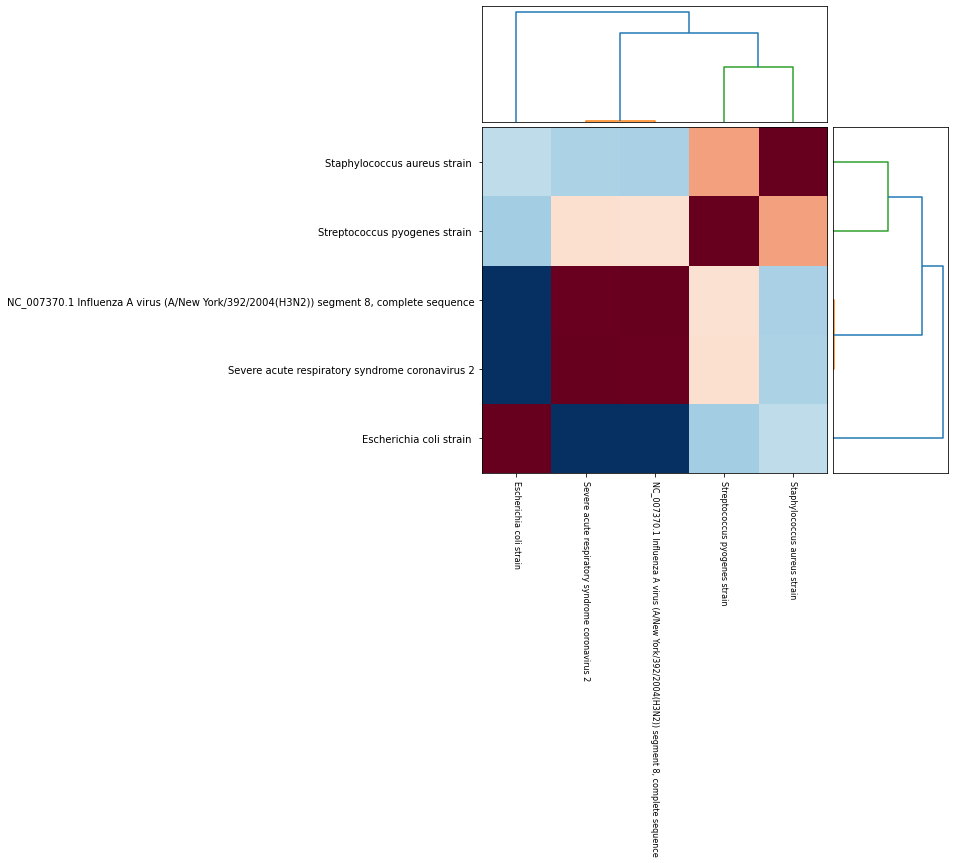

In [9]:
genomes = [genome.path for genome in os.scandir("genomes")]
organisms, distances = matrix_output(genomes, 4)
make_table(4, organisms, distances)

# Analyzing the results

[Back to main site](https://lawrencegordon.github.io/)